# Scalable Analysis of Bayesian Networks

We run experiments on some sample topologies.

In [1]:
import concurrent.futures
import os
import time

import networkx as nx
import numpy as np
import pandas as pd

from causalnex.structure.notears import from_pandas
from causalnex.structure import StructureModel
from networkx.classes import DiGraph
from sklearn.preprocessing import LabelEncoder
from typing import List, Tuple, Dict
from matplotlib import pyplot

# SAB Pipeline

In [2]:
class TopologyLabel:
    def __init__(self, nid: int, collider=False, chain=False, fork=False):
        self.nid : int = nid
        self.collider : bool = collider
        self.chain : bool = chain
        self.fork : bool = fork

    def __str__(self):
        return (f"{self.nid}: {{collider = {self.collider}, chain = {self.chain}, "
                f"fork = {self.fork}}}")

    def __repr__(self):
        return str(self)

def is_csv_file(file_path):
  return os.path.splitext(file_path)[1].lower() == '.csv'

def preprocessor(dataset: str) -> Tuple[StructureModel, float, float, float]:
    assert is_csv_file(dataset)
    start = time.perf_counter()
    data_pd = pd.read_csv(dataset)
    io_time = time.perf_counter() - start

    start = time.perf_counter()
    non_numeric_columns = list(data_pd.select_dtypes(exclude=[np.number]).columns)
    le = LabelEncoder()

    for col in non_numeric_columns:
        data_pd[col] = le.fit_transform(data_pd[col])
    enc_time = time.perf_counter() - start

    start = time.perf_counter()
    s_model = from_pandas(data_pd, w_threshold=0.8)
    nt_time = time.perf_counter() - start
    return s_model, io_time, enc_time, nt_time

def relabel(s_model: StructureModel) -> Tuple[DiGraph, List[int]]:
    mapping = dict()
    inv_mapping = []
    label = 0
    s = sorted(s_model.nodes)
    for s_node in s:
        mapping[s_node] = label
        label += 1
        inv_mapping.append(s_node)
    return nx.relabel_nodes(s_model, mapping), inv_mapping

def sab_threaded(dag: DiGraph, result : Dict[str, TopologyLabel], tid: int, n_threads: int) -> None:
    idx = tid
    n_nodes = len(dag.nodes)
    nodes = list(dag.nodes)
    while idx < n_nodes:
        v = nodes[idx]
        i_d = dag.in_degree(v)
        o_d = dag.out_degree(v)
        if i_d > 1:
            result[v].collider = True
        elif i_d == 1 and o_d >= 1:
            result[v].chain = True
        if o_d > 1:
            result[v].fork = True
        idx += n_threads

def sab_core(dag: DiGraph, parallel=False) -> Tuple[Dict[str, TopologyLabel], float]:
    start = time.perf_counter()
    assert nx.is_directed_acyclic_graph(dag)
    result : Dict[str, TopologyLabel] = {}
    for v in dag.nodes:
        result[v] = TopologyLabel(v)

    if not parallel:
        sab_threaded(dag, result, 0, 1)
    else:
        num_threads = min(8, len(dag.nodes))
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as sab_executor:
            for tid in range(num_threads):
                sab_executor.submit(sab_threaded, dag, result, tid, num_threads)
    alg_time = time.perf_counter() - start
    return result, alg_time

def sab(dataset: str, parallel=False) -> Tuple[Dict[str, TopologyLabel], float, float, float, float]:
    # preprocessing
    assert is_csv_file(dataset) and os.path.exists(dataset)
    dag, io_time, enc_time, nt_time = preprocessor(dataset)
    result, alg_time = sab_core(dag, parallel)
    return result, io_time, enc_time, nt_time, alg_time

## Pipeline

In [3]:
d_str = "datasets/student-por.csv"
data = pd.read_csv('datasets/student-por.csv')
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
data = data.drop(columns=drop_col)
data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,...,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,...,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,...,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,...,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,...,4,3,2,1,2,5,0,11,13,13


In [4]:
psm, io_t, enc_t, nt_t = preprocessor(d_str)

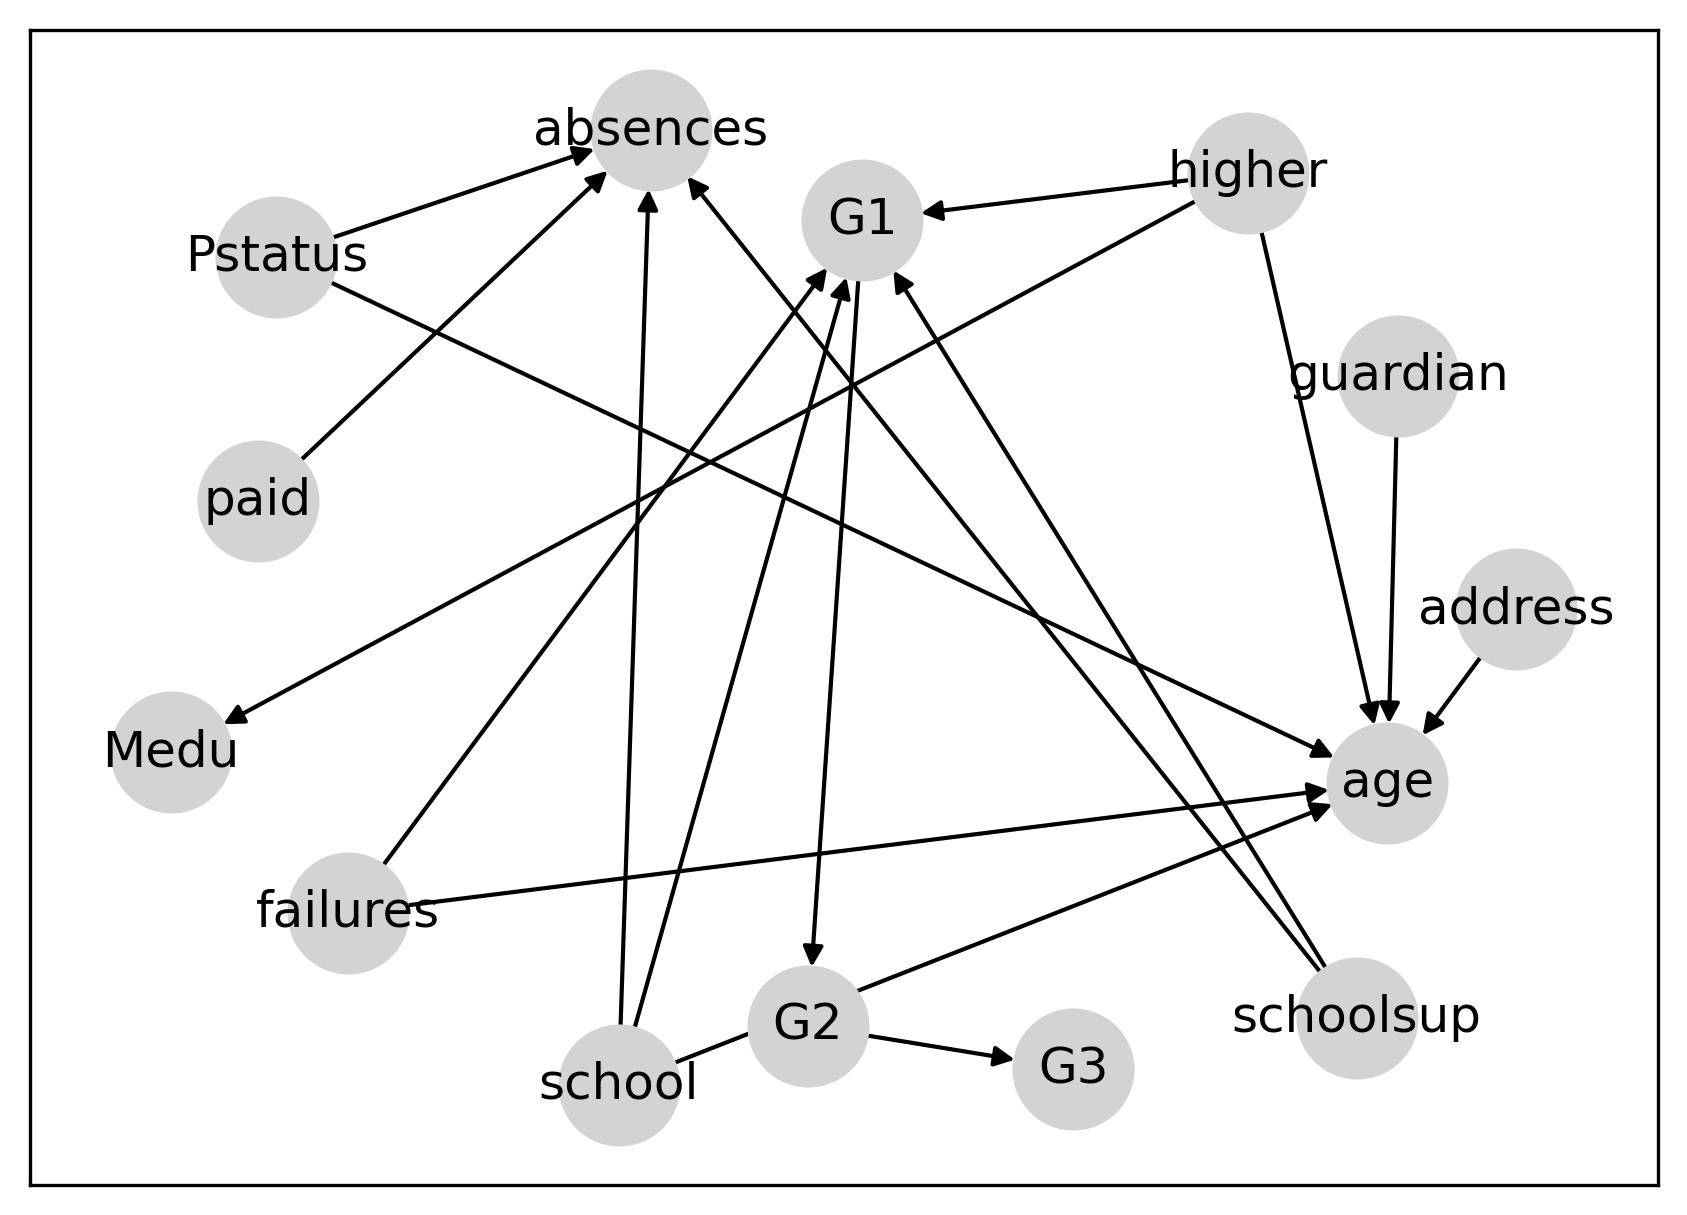

In [16]:
s_psm = psm.get_largest_subgraph()
fig, axs = pyplot.subplots(figsize=(7, 5), dpi=300)
pos = nx.spring_layout(s_psm, k=12, iterations=30)
nx.draw_networkx(s_psm, pos, font_color="black", node_color="lightgrey", node_size=800)
pyplot.savefig("uci_perf.pdf")
pyplot.show()

# Evaluation

In [83]:
d = nx.from_numpy_array(np.array([[0, 1, 0, 1, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]))
G = nx.DiGraph()
G.add_edges_from(d.edges)
print(G.edges)

[(0, 1), (0, 3), (1, 2), (3, 4), (2, 4)]


## Student Performance Math

In [87]:
d_str = "datasets/Math-Students.csv"
_, i_t, e_t, n_t, a_t = sab(d_str)
print(i_t, e_t, n_t, a_t)
_, i_t, e_t, n_t, a_t = sab(d_str, parallel=True)
print(i_t, e_t, n_t, a_t)

0.004435083999851486 0.003870624999763095 36.14977395800088 8.420899939665105e-05
0.0029369579988269834 0.0024055829999269918 35.653826583999034 0.0010339590007788502


In [89]:
d_str = "datasets/heart_cleveland_upload.csv"
_, i_t, e_t, n_t, a_t = sab(d_str)
print(i_t, e_t, n_t, a_t)
_, i_t, e_t, n_t, a_t = sab(d_str, parallel=True)
print(i_t, e_t, n_t, a_t)

0.002411458999631577 5.158300155017059e-05 5.499184583000897 5.504200089490041e-05
0.0010653750014171237 3.1207999199978076e-05 5.459357583000383 0.00043650000043271575


In [ ]:
d_str = "datasets/heart_cleveland_upload.csv"
_, i_t, e_t, n_t, a_t = sab(d_str)
print(i_t, e_t, n_t, a_t)
_, i_t, e_t, n_t, a_t = sab(d_str, parallel=True)
print(i_t, e_t, n_t, a_t)

In [107]:
nd = 4 * 1024
d = np.tril(np.ones((nd, nd), dtype=int), -1)
dg = nx.from_numpy_array(d)
G = nx.DiGraph()
G.add_edges_from(dg.edges)

In [108]:
r, alg_t = sab_core(G)
print(alg_t)
r, alg_t = sab_core(G, parallel=True)
print(alg_t)

1.0972462919999089
0.9575762500007841
